In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

import os
import openai
openai.api_key = os.getenv("OPENAI_API_KEY")


In [2]:
def getAccuracy(completion_eqns, expected_completion_eqns, eval_dict):

    spaced_eval_dict = eval_dict
    spaced_keys =spaced_eval_dict.keys()

    eval_dict={}
    for key in spaced_keys:
        eval_dict[key.replace(' ','')] = spaced_eval_dict[key]

    def LHSOfEqn(eqn_str):
        first_equals = eqn_str.find('=')
        LHS = eqn_str[0:first_equals].replace(' ', '')
        return LHS

    def RHSOfEqn(eqn_str):
        last_equals = eqn_str.rfind('=')
        RHS = eqn_str[last_equals+1:].replace(' ', '')
        return RHS

    '''
    metric = value | verbatim
    accuracyType = numCorrectOverTotal | firstIncorrectOverTotal

    ((accuracy[type])[metric]) = a number

    accuracy = {
        numCorrectAcc: {
            value: ...,
            verbatim: ...,
        },
        firstIncorrectAcc: {
            value: ...,
            verbatim: ...,
        }
    }
    '''
    numCorrectAcc = {"value": 0, "verbatim": 0}
    firstIncorrectAcc = {"value": 1, "verbatim": 1}
    _firstIncorrectValNotFound = True
    _firstIncorrectVerbNotFound = True

    num_expected_eqns = len(expected_completion_eqns)
    for i in range(num_expected_eqns):
        expected_eqn = expected_completion_eqns[i]

        try:
            completion_eqn = completion_eqns[i]
        except:
            completion_eqn = ''

        completion_LHS, completion_RHS = LHSOfEqn(
            completion_eqn), RHSOfEqn(completion_eqn)

        try:
            equal_verbatim = (completion_eqn == expected_eqn)
        except:
            equal_verbatim = False

        try:
            equal_value = (eval_dict[completion_LHS]
                           == int(completion_RHS[-2:]))
        except:
            equal_value = False

        numCorrectAcc["value"] += int(equal_value) / num_expected_eqns
        numCorrectAcc["verbatim"] += int(equal_verbatim) / num_expected_eqns

        if (not equal_value) and _firstIncorrectValNotFound:
            firstIncorrectAcc["value"] = i / num_expected_eqns
            _firstIncorrectValNotFound = False
        if (not equal_verbatim) and _firstIncorrectVerbNotFound:
            firstIncorrectAcc["verbatim"] = i / num_expected_eqns
            _firstIncorrectVerbNotFound = False

    accuracy = {
        "numCorrectAcc": numCorrectAcc,
        "firstIncorrectAcc": firstIncorrectAcc,
    }

    return accuracy


def averageOfAccuracies(accs):
    acc_avg = {
        "numCorrectAcc": {
            "value": 0,
            "verbatim": 0,
        },
        "firstIncorrectAcc": {
            "value": 0,
            'verbatim': 0,
        }
    }

    for acc in accs:
        for _type in acc.keys():
            for _metric in acc[_type].keys():
                acc_avg[_type][_metric] += acc[_type][_metric] / len(accs)

    return acc_avg


def strToEqns(text):
    _completion_lines = text.split('\n')
    _completion_lines = [eqn.replace('\n', '') for eqn in _completion_lines]
    _eqn_idxs = [i for i, completion_line in enumerate(
        _completion_lines) if '=' in completion_line]
    eqns = [_completion_lines[eqn_idx] for eqn_idx in _eqn_idxs]
    return eqns


In [3]:
def getACC_OF_HINTLEN(experiments,experiments_config):
    _ACCS_OF_HINTLEN = {}  # HINTLEN_VS_ACC[len] = list of accuracies
    _EXPECTED_ACC_OF_HINTLEN = {}

    num_experiments = len(experiments)
    for i_expt in range(num_experiments):

        trials = experiments[i_expt]
        config = experiments_config[i_expt]

        HINTLEN = int(config.NUM_NAME_HINTS)
        _ACCS_OF_HINTLEN[HINTLEN] = []
        _EXPECTED_ACC_OF_HINTLEN[HINTLEN] = max(float((config.NUM_NAME_HINTS - config.NUM_EQN_HINTS) / (
            config.NUM_VARS-config.NUM_EQN_HINTS)), 0)  # acc if hint correct and rest incorrect

        num_trials = len(trials)
        for i_trial in range(num_trials):
            trial = trials.iloc[i_trial]

            completion_text = trial.completion
            expected_completion_text = trial.expected_completion
            eval_dict = trial.eval_dict

            completion_eqns = strToEqns(completion_text)
            expected_completion_eqns = strToEqns(expected_completion_text)

            _ACC = getAccuracy(completion_eqns, expected_completion_eqns, eval_dict)

            _ACCS_OF_HINTLEN[HINTLEN].append(_ACC)

    return _ACCS_OF_HINTLEN,_EXPECTED_ACC_OF_HINTLEN
    

In [4]:
experiments = []
experiments_config = []

for hint_len in range(0, 12+1, 2):
    experiments.append(pd.read_json(
        rf'data/[5]{hint_len}_hints,12_var,model_text-davinci-002.json', orient='records'))
    experiments_config.append(pd.read_json(
        rf'data/[config][5]{hint_len}_hints,12_var,model_text-davinci-002.json', orient='records'))


In [5]:
accOfLen, expectedAccOfLen = getACC_OF_HINTLEN(experiments,experiments_config)

avgAccOfLen = {}  # accuracy of hint length averaged over all trials

for hintlen in accOfLen.keys():
    avgAccOfLen[hintlen] = averageOfAccuracies(accOfLen[hintlen])

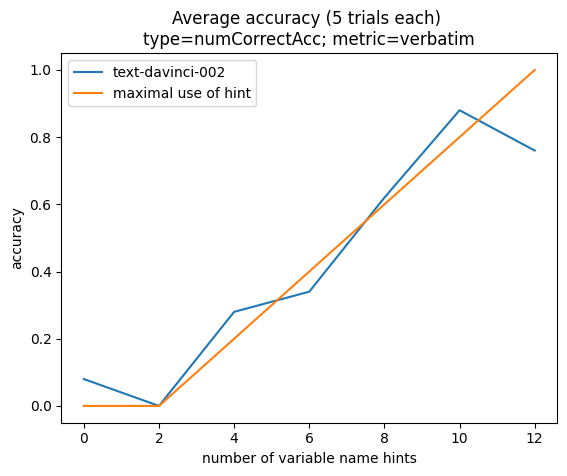

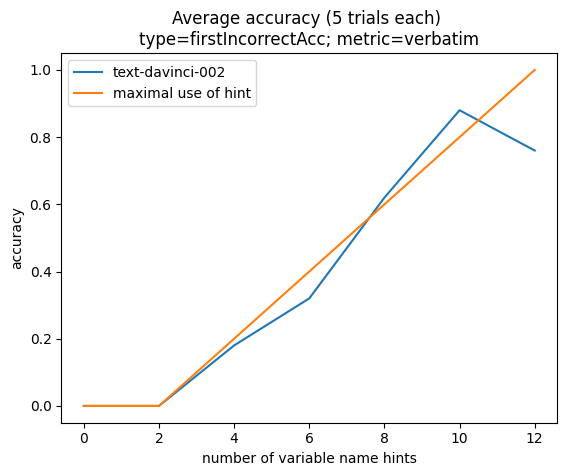

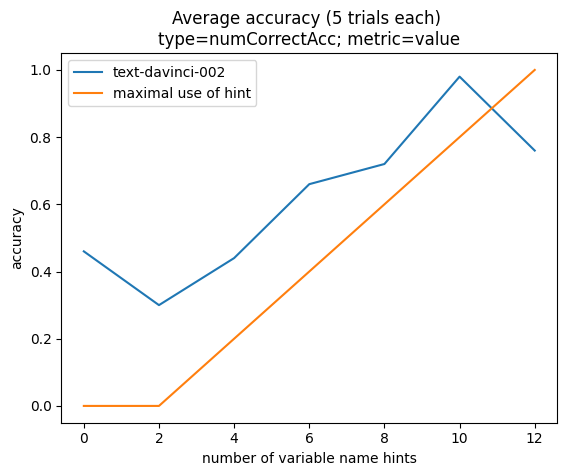

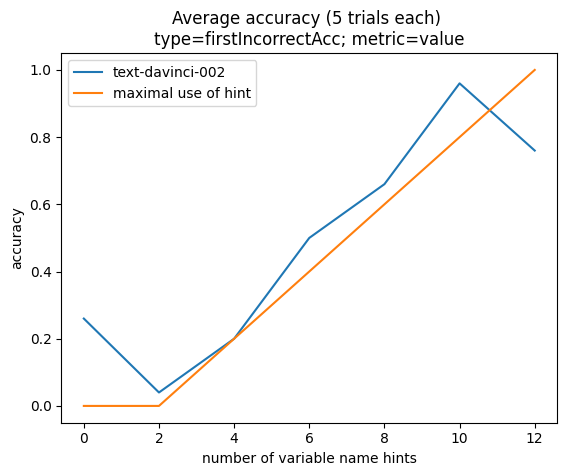

In [6]:
ACC_TYPES =  ['numCorrectAcc', 'firstIncorrectAcc']
ACC_METRICS = ['verbatim','value']  # 'verbatim' | 'value'


for acc_metric in ACC_METRICS:
    for acc_type in ACC_TYPES:
        xs = avgAccOfLen.keys()
        ys = [avgAccOfLen[key][acc_type][acc_metric] for key in avgAccOfLen.keys()]
        plt.plot(xs,ys, label='text-davinci-002')

        ys_expected = expectedAccOfLen.values()
        plt.plot(xs,ys_expected,label='maximal use of hint')


        plt.xlabel('number of variable name hints')
        plt.ylabel('accuracy')
        plt.title(f'Average accuracy (5 trials each) \ntype={acc_type}; metric={acc_metric}')
        plt.legend()
        plt.show()